# Agent Evaluation
In this notebook we build an evaluation pipeline to test our model in different scenarios:
- Retrieving data from the database
- Searching Wikipedia
- Searching Youtube

## Installs and imports

In [2]:
# load env vars
import os
from dotenv import load_dotenv
load_dotenv(override=True)  # change project evaluation name in environment

if os.environ.get('OPENAI_API_KEY', ''):
    print('OPENAI_API_KEY is set')
print('Langchain project:', os.environ.get('LANGCHAIN_PROJECT', ''))

OPENAI_API_KEY is set
Langchain project: ik-multimodal-ai-librarian


## Get our langchain model
Let's create an instance of the same langchain model that we use in our app. We restrict the access to the tool(s) we are evaluating.

In [3]:
# create an agent
import tools
from ai_librarian import AiLibrarian

avatar = AiLibrarian()

# restrict the agent to only use these tools
agent_tools = [
    tools.search_database_for_book_information,
    # tools.search_database_for_book_reviews,
    # tools.wikipedia_search_tool,
    # tools.youtube_search_tool,
    # tools.retrieve_youtube_transcript_from_url,
    # tools.get_information_about_yourself,
]

avatar.create_worker_agent(agent_tools)

# test the agent
avatar.generate_model_answer('The Three Musketeers')


c:\Users\Nath\anaconda3\envs\ironhack\Lib\site-packages\sentence_transformers\cross_encoder\CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


c:\Development\_repos\Ironhack\Projects\ik-multimodal-ai-librarian\models.py:101: LangChainDeprecationWarning: Please see the migration guide at: https://python.langchain.com/docs/versions/migrating_memory/
  memory = ConversationBufferWindowMemory(




> Entering new AgentExecutor chain...

Invoking: `search_database_for_book_information` with `{'query_text': 'The Three Musketeers'}`




Batches:   0%|          | 0/1 [00:00<?, ?it/s]

{'documents': [["The Three Musketeers (A Stepping Stone Book(TM)) - In seventeenth-century France, young D'Artagnan befriends three musketeers, Athos, Porthos, and Aramis, and joins them in trying to outwit the enemies of the king and queen. Simultaneous. -  Juvenile Fiction , Action & Adventure , General", "The Three Musketeers is a classic novel by Alexandre Dumas, published in 1844, which follows the adventures of d'Artagnan, a young man who travels to Paris to join the Musketeers of the Guard. He befriends three musketeers—Athos, Porthos, and Aramis—and together they engage in various escapades involving political intrigue, romance, and duels. The story is set in the 17th century and explores themes of friendship, loyalty, and honor, as d'Artagnan navigates the complexities of court life and battles against the schemes of the villainous Cardinal Richelieu and Milady de Winter. The novel is renowned for its vibrant characters and thrilling plot, making it a timeless adventure tale."

'"The Three Musketeers," penned by Alexandre Dumas and published in 1844, unfolds the adventures of young d’Artagnan as he seeks to join the Musketeers of the Guard in 17th-century France. Uplifted by the bonds of camaraderie with Athos, Porthos, and Aramis, they navigate intrigue, honor, and rivalry, primarily embroiled in conflicted loyalties to the king and the sly manipulations of Cardinal Richelieu. The enduring themes of friendship and bravery echo through its lively narration, providing heartfelt insights on loyalty formatted within thrilling interludes.'

## Create Evaluator

In [4]:
from langchain_openai import ChatOpenAI
from langchain.docstore.document import Document
from langchain_core.prompts import ChatPromptTemplate
from langchain.chains.combine_documents import create_stuff_documents_chain

### Answer Score
Let's rate the answer of our model compared to the user query


In [5]:
def answer_score(query: str, context: str) -> bool:
    
    prompt_text = """
    You are an evaluator for a conversational AI system. The user asked:
    "{query}"
    
    The AI responded with:
    "{context}"
    
    Please grade on a scale from 0 to 5 if the response is 
    - Relevant to the question and answers the question
    - A sensible, non-recursive, and complete answer
    - Grammatically correct
    - Engaging and informative
    - Free of factual errors
    - Free of offensive content

    Answer with a single integer from 0 to 5, 0 being the worst and 5 being the best score.
    """

    prompt = ChatPromptTemplate.from_messages(
        [("system", prompt_text),]
    )

    llm = ChatOpenAI(
        temperature=0,
        model_name='gpt-4o-mini',
        api_key=os.getenv("OPENAI_API_KEY")
    )

    chain = create_stuff_documents_chain(llm, prompt)
    document = Document(page_content=context)
    return chain.invoke({"context": [document], "query": query})

query = 'Tell me about The Three Musketeers'
context = avatar.generate_model_answer(query)
print('ANSWER SCORE:', answer_score(query, context))

context = 'The three musketeers is a cartoon with dogs for children'
print('ANSWER SCORE:', answer_score(query, context))



> Entering new AgentExecutor chain...

Invoking: `search_database_for_book_information` with `{'query_text': 'The Three Musketeers'}`




Batches:   0%|          | 0/1 [00:00<?, ?it/s]

{'documents': [["The Three Musketeers (A Stepping Stone Book(TM)) - In seventeenth-century France, young D'Artagnan befriends three musketeers, Athos, Porthos, and Aramis, and joins them in trying to outwit the enemies of the king and queen. Simultaneous. -  Juvenile Fiction , Action & Adventure , General", "The Three Musketeers is a classic novel by Alexandre Dumas, published in 1844, which follows the adventures of d'Artagnan, a young man who travels to Paris to join the Musketeers of the Guard. He befriends three musketeers—Athos, Porthos, and Aramis—and together they engage in various escapades involving political intrigue, romance, and duels. The story is set in the 17th century and explores themes of friendship, loyalty, and honor, as d'Artagnan navigates the complexities of court life and battles against the schemes of the villainous Cardinal Richelieu and Milady de Winter. The novel is renowned for its vibrant characters and thrilling plot, making it a timeless adventure tale."

### Sanity Check
A sanity check is a simple check to ensure that the agent’s response is not nonsensical, empty, or wildly irrelevant. For instance, a response should not be blank, too short, or completely unrelated.

In [6]:
def sanity_check(query: str, context: str) -> bool:
    
    prompt_text = """
    You are an evaluator for a conversational AI system. The user asked:
    "{query}"
    
    The AI responded with:
    "{context}"
    
    Please determine if the response is:
    - Relevant to the question
    - A sensible, non-recursive, and complete answer

    Answer with only "True" if it passes the sanity check and "False" if it does not.
    """

    prompt = ChatPromptTemplate.from_messages(
        [("system", prompt_text),]
    )

    llm = ChatOpenAI(
        temperature=0,
        model_name='gpt-4o-mini',
        api_key=os.getenv("OPENAI_API_KEY")
    )

    chain = create_stuff_documents_chain(llm, prompt)
    document = Document(page_content=context)
    return chain.invoke({"context": [document], "query": query})

query = 'Tell me about The Three Musketeers'
context = avatar.generate_model_answer(query)
print('SANITY CHECK:', sanity_check(query, context))

context = 'The three musketeers is a cartoon with dogs for children'
print('SANITY CHECK:', sanity_check(query, context))



> Entering new AgentExecutor chain...

Invoking: `search_database_for_book_information` with `{'query_text': 'The Three Musketeers'}`




Batches:   0%|          | 0/1 [00:00<?, ?it/s]

{'documents': [["The Three Musketeers (A Stepping Stone Book(TM)) - In seventeenth-century France, young D'Artagnan befriends three musketeers, Athos, Porthos, and Aramis, and joins them in trying to outwit the enemies of the king and queen. Simultaneous. -  Juvenile Fiction , Action & Adventure , General", "The Three Musketeers is a classic novel by Alexandre Dumas, published in 1844, which follows the adventures of d'Artagnan, a young man who travels to Paris to join the Musketeers of the Guard. He befriends three musketeers—Athos, Porthos, and Aramis—and together they engage in various escapades involving political intrigue, romance, and duels. The story is set in the 17th century and explores themes of friendship, loyalty, and honor, as d'Artagnan navigates the complexities of court life and battles against the schemes of the villainous Cardinal Richelieu and Milady de Winter. The novel is renowned for its vibrant characters and thrilling plot, making it a timeless adventure tale."

### Response Time
Let's create a method to calculate the response time

In [7]:
import time

def generate_model_answer_timed(query: str) -> tuple[str, float]:
    start = time.time()
    answer = avatar.generate_model_answer(query)
    end = time.time()
    response_time = end - start
    return answer, response_time

query = 'Tell me about the Three Musketeers'
answer, gen_time = generate_model_answer_timed(query)
print(answer)
print(f"Response time: {gen_time} seconds")



> Entering new AgentExecutor chain...

Invoking: `search_database_for_book_information` with `{'query_text': 'The Three Musketeers'}`




Batches:   0%|          | 0/1 [00:00<?, ?it/s]

{'documents': [["The Three Musketeers (A Stepping Stone Book(TM)) - In seventeenth-century France, young D'Artagnan befriends three musketeers, Athos, Porthos, and Aramis, and joins them in trying to outwit the enemies of the king and queen. Simultaneous. -  Juvenile Fiction , Action & Adventure , General", "The Three Musketeers is a classic novel by Alexandre Dumas, published in 1844, which follows the adventures of d'Artagnan, a young man who travels to Paris to join the Musketeers of the Guard. He befriends three musketeers—Athos, Porthos, and Aramis—and together they engage in various escapades involving political intrigue, romance, and duels. The story is set in the 17th century and explores themes of friendship, loyalty, and honor, as d'Artagnan navigates the complexities of court life and battles against the schemes of the villainous Cardinal Richelieu and Milady de Winter. The novel is renowned for its vibrant characters and thrilling plot, making it a timeless adventure tale."

### Evaluate Readability
The Flesch Reading Ease score is a popular readability test used to evaluate how easy a text is to read. It’s particularly useful in ensuring your chatbot's responses are clear and accessible to your target audience.

Score Interpretation
The Flesch Reading Ease Score ranges from 0 to 100, with higher scores indicating easier readability. Here’s a breakdown:

Score Range	Description	Readability Level  
90 - 100	Very Easy	5th grade  
80 - 89	Easy	6th grade  
70 - 79	Fairly Easy	7th grade  
60 - 69	Standard	8th-9th grade  
50 - 59	Fairly Difficult	High school  
30 - 49	Difficult	College  
0 - 29	Very Confusing	College graduate and above  


In [8]:
from textstat import flesch_reading_ease

def readability_score(text: str) -> float:
    # Higher scores indicate easier readability
    return flesch_reading_ease(text)

query = 'Tell me about the Three Musketeers'
answer = avatar.generate_model_answer(query)
score = readability_score(answer)
print(f"Readability score: {score}")



> Entering new AgentExecutor chain...

Invoking: `search_database_for_book_information` with `{'query_text': 'The Three Musketeers'}`




Batches:   0%|          | 0/1 [00:00<?, ?it/s]

{'documents': [["The Three Musketeers (A Stepping Stone Book(TM)) - In seventeenth-century France, young D'Artagnan befriends three musketeers, Athos, Porthos, and Aramis, and joins them in trying to outwit the enemies of the king and queen. Simultaneous. -  Juvenile Fiction , Action & Adventure , General", "The Three Musketeers is a classic novel by Alexandre Dumas, published in 1844, which follows the adventures of d'Artagnan, a young man who travels to Paris to join the Musketeers of the Guard. He befriends three musketeers—Athos, Porthos, and Aramis—and together they engage in various escapades involving political intrigue, romance, and duels. The story is set in the 17th century and explores themes of friendship, loyalty, and honor, as d'Artagnan navigates the complexities of court life and battles against the schemes of the villainous Cardinal Richelieu and Milady de Winter. The novel is renowned for its vibrant characters and thrilling plot, making it a timeless adventure tale."

### Response length
Let's see how long an answer is in terms of characters, words and tokens

In [9]:
import tiktoken
encoding = tiktoken.get_encoding("cl100k_base")  # for gpt4o models

def answer_length(text: str) -> int:
    # initialise the tokenizer

    characters = len(text)
    words = len(text.split())
    tokens = len(encoding.encode(text))

    return characters, words, tokens

query = 'Tell me about the Three Musketeers'
answer = avatar.generate_model_answer(query)
length = answer_length(answer)
print(f"Character count: {length[0]}")
print(f"Word count: {length[1]}")
print(f"Token count: {length[2]}")



> Entering new AgentExecutor chain...

Invoking: `search_database_for_book_information` with `{'query_text': 'The Three Musketeers'}`




Batches:   0%|          | 0/1 [00:00<?, ?it/s]

{'documents': [["The Three Musketeers (A Stepping Stone Book(TM)) - In seventeenth-century France, young D'Artagnan befriends three musketeers, Athos, Porthos, and Aramis, and joins them in trying to outwit the enemies of the king and queen. Simultaneous. -  Juvenile Fiction , Action & Adventure , General", "The Three Musketeers is a classic novel by Alexandre Dumas, published in 1844, which follows the adventures of d'Artagnan, a young man who travels to Paris to join the Musketeers of the Guard. He befriends three musketeers—Athos, Porthos, and Aramis—and together they engage in various escapades involving political intrigue, romance, and duels. The story is set in the 17th century and explores themes of friendship, loyalty, and honor, as d'Artagnan navigates the complexities of court life and battles against the schemes of the villainous Cardinal Richelieu and Milady de Winter. The novel is renowned for its vibrant characters and thrilling plot, making it a timeless adventure tale."

### Lexical Overlap

In [10]:
from sentence_transformers import SentenceTransformer, util
from nltk.tokenize import word_tokenize
import numpy as np
from nltk.corpus import stopwords

# Initialize the model
model = SentenceTransformer('all-MiniLM-L6-v2')

def semantic_overlap(query: str, answer: str) -> float:
    # Tokenize and filter stop words
    stopwords_en = stopwords.words('english')
    query_words = set([word for word in word_tokenize(query.lower()) if word not in stopwords_en])
    answer_words = set([word for word in word_tokenize(answer.lower()) if word not in stopwords_en])
    
    # Compute embeddings
    query_embedding = model.encode(' '.join(query_words))
    answer_embedding = model.encode(' '.join(answer_words))
    
    # Calculate cosine similarity
    similarity_score = util.cos_sim(query_embedding, answer_embedding).item()
    
    return similarity_score

# Example usage
query = 'Tell me about the Three Musketeers'
answer = avatar.generate_model_answer(query)
semantic_score = semantic_overlap(query, answer)
print(f"Semantic overlap score: {semantic_score}")




> Entering new AgentExecutor chain...

Invoking: `search_database_for_book_information` with `{'query_text': 'The Three Musketeers'}`




Batches:   0%|          | 0/1 [00:00<?, ?it/s]

{'documents': [["The Three Musketeers (A Stepping Stone Book(TM)) - In seventeenth-century France, young D'Artagnan befriends three musketeers, Athos, Porthos, and Aramis, and joins them in trying to outwit the enemies of the king and queen. Simultaneous. -  Juvenile Fiction , Action & Adventure , General", "The Three Musketeers is a classic novel by Alexandre Dumas, published in 1844, which follows the adventures of d'Artagnan, a young man who travels to Paris to join the Musketeers of the Guard. He befriends three musketeers—Athos, Porthos, and Aramis—and together they engage in various escapades involving political intrigue, romance, and duels. The story is set in the 17th century and explores themes of friendship, loyalty, and honor, as d'Artagnan navigates the complexities of court life and battles against the schemes of the villainous Cardinal Richelieu and Milady de Winter. The novel is renowned for its vibrant characters and thrilling plot, making it a timeless adventure tale."

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Semantic overlap score: 0.48450422286987305


### Entity Agreement
NOT WORKING

In [10]:
# import nltk
# nltk.download('maxent_ne_chunker_tab')
# nltk.download('words')
# from nltk import ne_chunk, pos_tag, word_tokenize

# def extract_entities(text):
#     # Extract named entities from text
#     chunks = ne_chunk(pos_tag(word_tokenize(text)))
#     print(chunks.leaves())
#     entities = [" ".join([token for token, _ in chunk.leaves()])
#             for chunk in chunks if hasattr(chunk, 'label')]
#     print(f"Extracted entities from '{text}': {entities}")  # Debug output
#     return entities

# def entity_agreement(query, answer):
#     # Extract entities in answer and query
#     query_entities = set(extract_entities(query.lower()))
#     answer_entities = set(extract_entities(answer.lower()))

#     print(f"Entities in query: {query_entities}")  # Debug output
#     print(f"Entities in answer: {answer_entities}")  # Debug output

#     # Calculate proportion of entities in answer that are also in query
#     if not answer_entities:
#         return 0
#     return len(answer_entities.intersection(query_entities)) / len(answer_entities)

# Example Usage
# query = 'Tell me about the Three Musketeers'
# answer = 'The Three Musketeers is a novel by Alexandre Dumas.'
# # answer = avatar.generate_model_answer(query)
# agreement_score = entity_agreement(query, answer)
# print(f"Entity Agreement Score: {agreement_score}")


## Evaluation pipeline
Let's group all the tests into one evaluation pipeline and run it on samples

In [11]:
# create an empty dataframe
import os
import pandas as pd
from datetime import datetime

# create evaluatoin folder if it does not exist
os.makedirs('evaluation', exist_ok=True)
separator = 100 * '-'

def save_row_to_csv(file: str, row: dict) -> None:

    # check if the file exists
    if os.path.exists(file):
        # load the existing dataframe
        df = pd.read_csv(file)
    else:
        # create a new dataframe
        df = pd.DataFrame(columns=[
            'query',
            'response_time',
            'answer_score',
            'sanity_check',
            'readability_score',
            'character_count',
            'word_count',
            'token_count',
            'semantic_overlap',
        ])

    # add the new row to the dataframe
    df.loc[len(df)] = row

    # save the dataframe to a csv file
    df.to_csv(file, index=False)


def run_evaluation(queries: list[str], title: str = 'evaluation_results') -> str:
    """Run the evaluation for a list of queries

    Args:
        queries (list[str]): List of queries to evaluate

    Returns:
        str: Path to the csv file containing the evaluation results

    Raises:
        Exception: If there is an error with a query (skips the query and continues)
    """

    csv_file = f'evaluation/{title}_{datetime.now().strftime("%Y%m%d_%H%M%S")}.csv'

    counter = 0
    n_queries = len(queries)

    for query in queries:
        
        # print progress
        counter += 1
        print(f"{separator}\nProgress: {counter}/{n_queries} | Query: {query}\n{separator}")

        # generate answer and run all the tests
        try:
            answer, response_time = generate_model_answer_timed(query)
            score = answer_score(query, answer)
            sanity = sanity_check(query, answer)
            readability = readability_score(answer)
            characters, words, tokens = answer_length(answer)
            semantic = semantic_overlap(query, answer)
        except Exception as e:
            print(f"Error with query {query}: {e}")
            continue

        # store results in a dictionary
        row = {
            'query': query,
            'response_time': response_time,
            'answer_score': score,
            'sanity_check': sanity,
            'readability_score': readability,
            'character_count': characters,
            'word_count': words,
            'token_count': tokens,
            'semantic_overlap': semantic,
        }

        # add row to csv file
        save_row_to_csv(csv_file, row)

    return csv_file



## Run Evaluations


### Evaluation 1: Database calls
In this first evaluation, we will ask the agent for information about books that are already in the database. We will therefore evaluate how it retrieves information from the database only.

Note: The agent is fetching information from the book_info collection using `vector_db.search_collection`. It filters the result based on distance values and the agent summarizes the results in its answer.

In [12]:
# load 100 books from the dataset we loaded into the database

# load the clean dataset into a dataframe
df = pd.read_csv('datasets/BooksDatasetClean.csv')

# get random titles (queries) and descriptions, store them in a list
n_titles = 100
queries = df.sample(n=n_titles)['Title'].tolist()
print(queries)


['Breast Cancer: The Complete Guide: Third Edition', 'The Wall Street Journal Lifetime Guide to Money: Strategies for Managing Your Finances', 'Rivers West: A Novel (Talon and Chantry)', 'The Way Forward Is with a Broken Heart', 'Change Forces - The Sequel (Educational Change and Development Series)', 'The Struggle for Black Equality, 1954-1980 (American Century Series)', 'Leading and Managing in Nursing', 'The Swan Thieves: A Novel', 'CSS: The Definitive Guide: The Definitive Guide', "What's Bred in the Bone (Cornish Trilogy)", 'The Profession: A Thriller', 'Half the Sky: Turning Oppression into Opportunity for Women Worldwide', 'Bubble Gum In The Sky - Pbk (First-Start Easy Reader)', 'How the Internet Works: Millennium Edition', 'Faithful Travelers: A Father, His Daughter, A Fly-fishing Journey of the Heart', 'Antique Automobiles Coloring Book (Dover History Coloring Book)', 'The Cassini Division (Fall Revolution)', 'Incredible Hulk Book of Strength (DK Readers, Level 4)', 'The Close

### Evaluations 2 and 3: Wikipedia / Youtube calls
In this second and third evaluations, we query the agent with famous book names (to be sure they have a wikipedia entry or youtube reviews) and monitor calls to the wikipedia/youtube apis

In [13]:
# I asked chatGPT to give me a list of 100 books from the public domain
queries = [
    "Pride and Prejudice",
    "Moby-Dick",
    "War and Peace",
    "The Great Gatsby",
    "The Odyssey",
    "Crime and Punishment",
    "The Brothers Karamazov",
    "Jane Eyre",
    "Wuthering Heights",
    "Brave New World",
    "Ulysses",
    "The Iliad",
    "Anna Karenina",
    "Les Misérables",
    "The Count of Monte Cristo",
    "The Divine Comedy",
    "A Tale of Two Cities",
    "Dracula",
    "Frankenstein",
    "The Picture of Dorian Gray",
    "The Scarlet Letter",
    "Heart of Darkness",
    "The Grapes of Wrath",
    "The Adventures of Huckleberry Finn",
    "Don Quixote",
    "The Hobbit",
    "Lord of the Flies",
    "Fahrenheit 451",
    "Great Expectations",
    "Middlemarch",
    "Madame Bovary",
    "Emma",
    "The Sun Also Rises",
    "The Old Man and the Sea",
    "Gone with the Wind",
    "The Sound and the Fury",
    "Rebecca",
    "Catch-22",
    "The Time Machine",
    "The Call of the Wild",
    "White Fang",
    "The Wind in the Willows",
    "Treasure Island",
    "Journey to the Center of the Earth",
    "Robinson Crusoe",
    "David Copperfield",
    "Oliver Twist",
    "Uncle Tom's Cabin",
    "The Three Musketeers",
    "The Little Prince",
    "Gulliver's Travels",
    "Candide",
    "The Road",
    "The Jungle",
    "A Farewell to Arms",
    "The Secret Garden",
    "Of Mice and Men",
    "The Scarlet Pimpernel",
    "The Metamorphosis",
    "Siddhartha",
    "The Bell Jar",
    "Slaughterhouse-Five",
    "On the Road",
    "The Good Earth",
    "A Passage to India",
    "The Importance of Being Earnest",
    "The War of the Worlds",
    "Around the World in Eighty Days",
    "The Invisible Man",
    "Twenty Thousand Leagues Under the Sea",
    "The Prince and the Pauper",
    "A Connecticut Yankee in King Arthur's Court",
    "The Hunchback of Notre-Dame",
    "Tess of the d'Urbervilles",
    "The Call of Cthulhu",
    "The Strange Case of Dr. Jekyll and Mr. Hyde",
    "The Legend of Sleepy Hollow",
    "The Last of the Mohicans",
    "Little Women",
    "The Red Badge of Courage",
    "The Wonderful Wizard of Oz",
    "Peter Pan",
    "Alice's Adventures in Wonderland",
    "Through the Looking-Glass",
    "Moll Flanders",
    "Les Liaisons Dangereuses",
    "The Phantom of the Opera",
    "The Adventures of Sherlock Holmes",
    "The Return of Sherlock Holmes",
    "The Memoirs of Sherlock Holmes",
    "The Hound of the Baskervilles",
    "The Age of Innocence",
    "The House of Mirth",
    "Sons and Lovers",
    "Lady Chatterley's Lover",
    "The Tenant of Wildfell Hall",
    "Far from the Madding Crowd",
    "Vanity Fair",
    "The Man in the Iron Mask",
    "The Canterbury Tales",
    "Beowulf",
    "Paradise Lost",
    "The Federalist Papers"
]

# remove duplicates
queries = list(set(queries))

# make sure we have only 100 queries
queries = queries[:100]

# refine wikipedia queries to target books
# queries = [f"{q} (book)" for q in queries]

# refine youtube queries to target reviews
queries = [f"Youtube reviews on the book {q}" for q in queries]

print(len(queries))
print(queries)


100
['Youtube reviews on the book The War of the Worlds', 'Youtube reviews on the book The Return of Sherlock Holmes', 'Youtube reviews on the book A Passage to India', 'Youtube reviews on the book Sons and Lovers', 'Youtube reviews on the book Brave New World', 'Youtube reviews on the book The Grapes of Wrath', 'Youtube reviews on the book The Adventures of Sherlock Holmes', 'Youtube reviews on the book The Prince and the Pauper', "Youtube reviews on the book A Connecticut Yankee in King Arthur's Court", 'Youtube reviews on the book Paradise Lost', 'Youtube reviews on the book The Metamorphosis', 'Youtube reviews on the book A Tale of Two Cities', 'Youtube reviews on the book The House of Mirth', 'Youtube reviews on the book Catch-22', 'Youtube reviews on the book A Farewell to Arms', 'Youtube reviews on the book Ulysses', 'Youtube reviews on the book Far from the Madding Crowd', 'Youtube reviews on the book The Scarlet Pimpernel', 'Youtube reviews on the book The Jungle', 'Youtube re

### Start Evaluation

In [ ]:
# run the evaluation
title = 'youtube_calls_evaluation'
csv_file = run_evaluation(queries, title)

## Compute means
Load the results stored in the csv files and compute mean values.

In [15]:
import json
import pandas as pd

def compute_mean_results(csv_file: str) -> tuple[dict, str]:
    """Compute the mean of the evaluation results

    Args:
        csv_file (str): Path to the csv file

    Returns:
        dict: Mean results for each evaluation metric
        str: Path to the json file containing the mean results
    """

    # load csv file into a dataframe
    df_results = pd.read_csv(csv_file)

    # interate through the dataframe and store them in a dict
    mean_results = {}

    for column in df_results.columns:
        # skip question and answer columns
        if column in ['query', 'answer']:
            continue
        mean_results[f"mean_{column}"] = df_results[column].mean()

    # save results to a json file
    json_file = f'{csv_file.split(".")[0]}.json'
    with open(json_file, 'w') as f:
        json.dump(mean_results, f, indent=4)
    
    return mean_results, json_file

# compute the mean results
mean_results, json_file = compute_mean_results(csv_file)
for key, value in mean_results.items():
    print(f"{key}: {value}")

mean_response_time: 44.03691450754801
mean_answer_score: 3.087719298245614
mean_sanity_check: 0.2982456140350877
mean_readability_score: 16.992807017543857
mean_character_count: 11161.38596491228
mean_word_count: 1149.017543859649
mean_token_count: 3172.0
mean_semantic_overlap: 0.31231838335658896


## Fetch langsmith metrics
Let's fetch the project metrics from langsmith

In [16]:
from langsmith import Client

client = Client()
resp = client.read_project(project_name=os.environ.get('LANGCHAIN_PROJECT', ''), include_stats=True)
resp_dict = resp.dict()

for key, value in resp_dict.items():
    print(f"{key}: {value}")


id: eead172f-fa4b-4444-850b-4cf8e22a7ad1
start_time: 2024-11-07 13:39:33.251240
end_time: None
description: None
name: ai-librarian-youtube-calls-evaluation
extra: None
tenant_id: a78c39d8-d67b-5df4-ac33-c58f3235e5bf
reference_dataset_id: None
run_count: 214
latency_p50: 0:00:01.163000
latency_p99: 0:04:16.400280
total_tokens: 2976781
prompt_tokens: 2833573
completion_tokens: 143208
last_run_start_time: 2024-11-07 14:38:41.368180
feedback_stats: {}
run_facets: []
total_cost: 0.51096075
prompt_cost: 0.42503595
completion_cost: 0.0859248
first_token_p50: 0:00:01.299000
first_token_p99: 0:00:06.525200
error_rate: 0.19626168224299065


## Combine metrics
Let's add langsmith metrics to our json file


In [17]:
from decimal import Decimal

# load mean results from json and add langchain metrics to them
with open(json_file, 'r') as f:
    mean_results = json.load(f)

# token count
mean_results['total_prompt_tokens'] = resp_dict['prompt_tokens']
mean_results['total_completion_tokens'] = resp_dict['completion_tokens']
mean_results['total_tokens'] = resp_dict['total_tokens']
# costs (add 1k factor for readability)
mean_results['total_prompt_cost'] = resp_dict['prompt_cost'] * 1000
mean_results['total_completion_cost'] = resp_dict['completion_cost'] * 1000
mean_results['total_cost'] = resp_dict['total_cost'] * 1000
# latency times
mean_results['mean_latency_p50'] = resp_dict['latency_p50'].total_seconds()
mean_results['mean_latency_p99'] = resp_dict['latency_p99'].total_seconds()
mean_results['first_token_p50'] = resp_dict['first_token_p50'].total_seconds()
mean_results['first_token_p99'] = resp_dict['first_token_p99'].total_seconds()
# error rate
mean_results['mean_error_rate'] = resp_dict['error_rate']

# convert Decimal values (not json serializable) to float
mean_results = {k: float(v) if isinstance(v, Decimal) else v for k, v in mean_results.items()}

# overwrite the json file with the updated results
with open(json_file, 'w') as f:
    json.dump(mean_results, f, indent=4)

# print the updated results
for key, value in mean_results.items():
    print(f"{key}: {value}")

mean_response_time: 44.03691450754801
mean_answer_score: 3.087719298245614
mean_sanity_check: 0.2982456140350877
mean_readability_score: 16.992807017543857
mean_character_count: 11161.38596491228
mean_word_count: 1149.017543859649
mean_token_count: 3172.0
mean_semantic_overlap: 0.31231838335658896
total_prompt_tokens: 2833573
total_completion_tokens: 143208
total_tokens: 2976781
total_prompt_cost: 425.03595
total_completion_cost: 85.9248
total_cost: 510.96075
mean_latency_p50: 1.163
mean_latency_p99: 256.40028
first_token_p50: 1.299
first_token_p99: 6.5252
mean_error_rate: 0.19626168224299065


## Plot results
Let's generate plots for each metric to compare the 3 evaluations:
- database calls
- wikipedia queries
- youtube queries

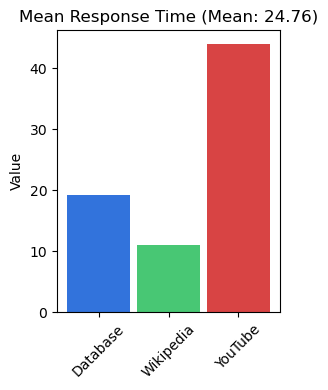

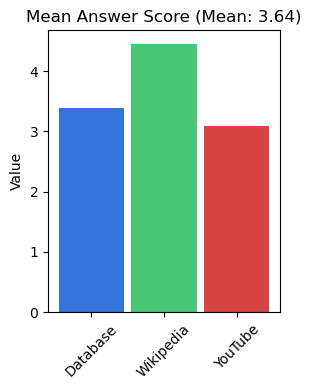

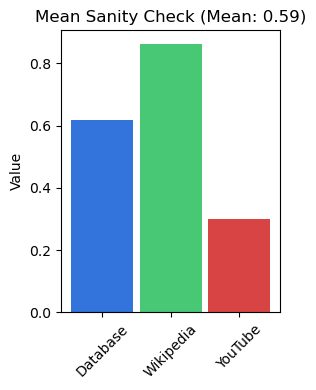

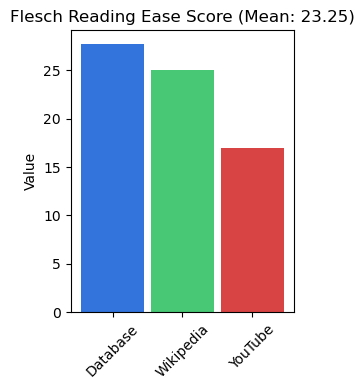

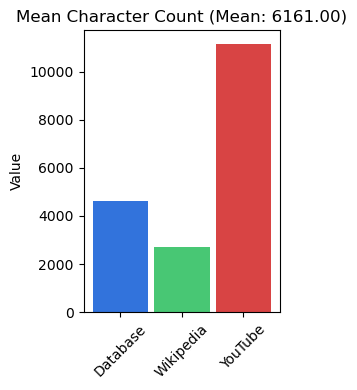

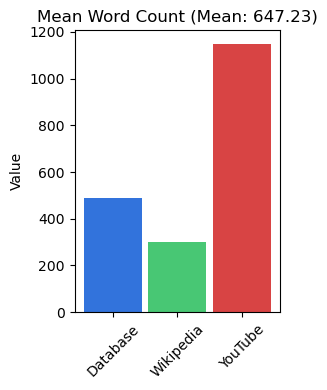

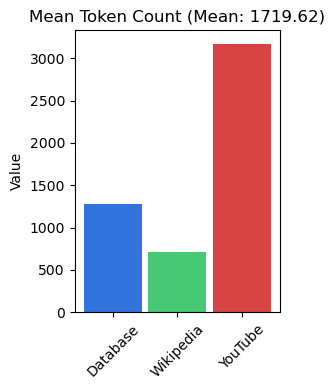

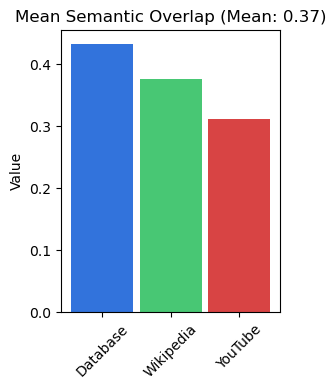

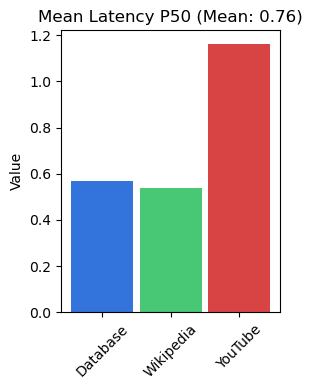

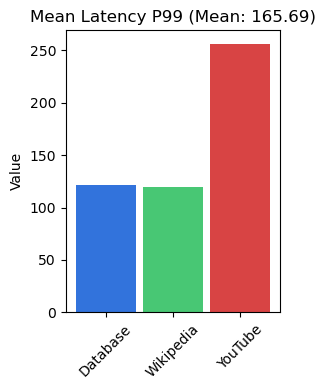

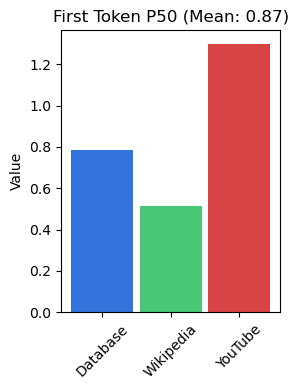

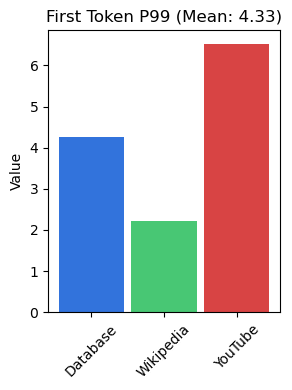

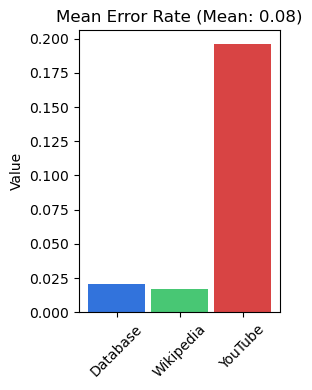

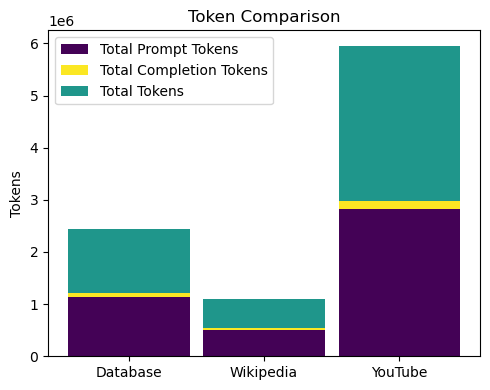

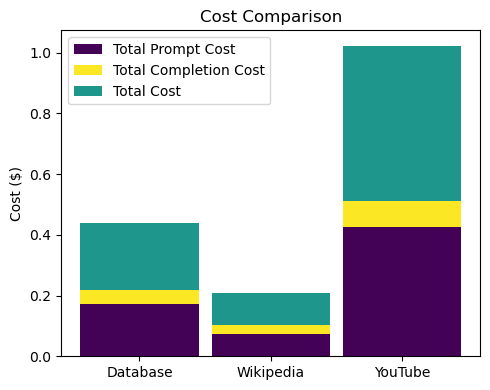

In [22]:
import json
import matplotlib.pyplot as plt
import numpy as np

colors_tools = ['#3273DC', '#48C774', '#d84444']  # Colors for database, wikipedia, youtube
colors_comparison = ['#440256', '#fbe723', '#1f968b']  # Colors for token and cost metrics
figsize = (3, 4)  # Smaller width for the individual bar charts
bar_width = 0.9  # Bar width for individual metrics

# Load data from JSON files
def load_data(filename):
    with open(filename, 'r') as f:
        return json.load(f)

# Load each JSON file
database = load_data('evaluation/database_calls_evaluation_20241107_110304.json')
wikipedia = load_data('evaluation/wikipedia_calls_evaluation_20241107_120850.json')
youtube = load_data('evaluation/youtube_calls_evaluation_20241107_143933.json')

# Group the data
data = {
    "database": database,
    "wikipedia": wikipedia,
    "youtube": youtube
}

# Separate metrics to plot individually
individual_metrics = [
    "mean_response_time", "mean_answer_score", "mean_sanity_check",
    "mean_readability_score", "mean_character_count", "mean_word_count",
    "mean_token_count", "mean_semantic_overlap", "mean_latency_p50",
    "mean_latency_p99", "first_token_p50", "first_token_p99", "mean_error_rate"
]

# Plot each individual metric as a bar chart with narrower bars and reduced chart width
for metric in individual_metrics:
    values = [data["database"][metric], data["wikipedia"][metric], data["youtube"][metric]]
    mean_value = np.mean(values)
    
    # Custom title for mean_readability_score
    title = "Flesch Reading Ease Score" if metric == "mean_readability_score" else metric.replace('_', ' ').title()
    
    plt.figure(figsize=figsize)  # Adjust figsize for smaller chart width
    plt.bar(["Database", "Wikipedia", "YouTube"], values, color=colors_tools, width=bar_width)  # Set bar width
    plt.title(f"{title} (Mean: {mean_value:.2f})")
    plt.ylabel('Value')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Separate metrics for tokens and costs to plot as grouped stacked bars
token_metrics = ["total_prompt_tokens", "total_completion_tokens", "total_tokens"]
cost_metrics = ["total_prompt_cost", "total_completion_cost", "total_cost"]

# Function to plot stacked bars with narrower chart width and adjusted cost values
def plot_stacked_bars(metric_list, title, ylabel, divide_by_1000=False):
    labels = ["Database", "Wikipedia", "YouTube"]
    values = {
        "Database": [data["database"][metric] / 1000 if divide_by_1000 else data["database"][metric] for metric in metric_list],
        "Wikipedia": [data["wikipedia"][metric] / 1000 if divide_by_1000 else data["wikipedia"][metric] for metric in metric_list],
        "YouTube": [data["youtube"][metric] / 1000 if divide_by_1000 else data["youtube"][metric] for metric in metric_list]
    }
    
    x = np.arange(len(labels))
    
    fig, ax = plt.subplots(figsize=(5, 4))  # Adjust figsize for narrower chart
    bottom = np.zeros(len(labels))
    
    for i, metric in enumerate(metric_list):
        ax.bar(x, [values[label][i] for label in labels], bar_width, label=metric.replace('_', ' ').title(), bottom=bottom, color=colors_comparison[i])
        bottom += np.array([values[label][i] for label in labels])
    
    ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()
    plt.tight_layout()
    plt.show()

# Plot token and cost metrics as stacked bar charts with adjusted width
plot_stacked_bars(token_metrics, "Token Comparison", "Tokens")
plot_stacked_bars(cost_metrics, "Cost Comparison", "Cost ($)", divide_by_1000=True)
